In [22]:
import cv2
import yaml
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [23]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)

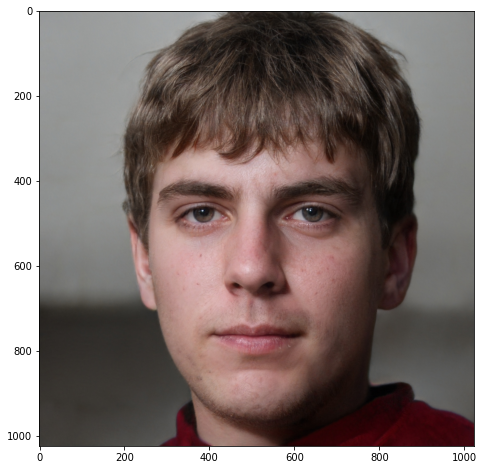

In [24]:
# image generated from https://thispersondoesnotexist.com/

img_path = "../input/image.jpg"

src = cv2.imread(img_path)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
img = src.copy()
plt.imshow(img)
plt.savefig("../output/makeup/before.png")

In [25]:
def read_yaml(path):
    with open(path, "r") as f:
        cfg = yaml.safe_load(f)
    return cfg

cfg = read_yaml("../config/make_up.yaml")

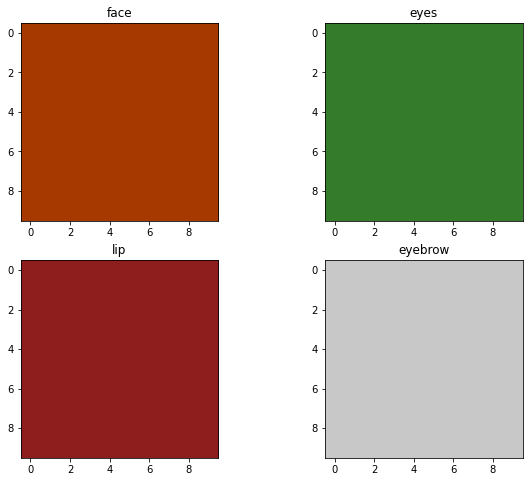

In [26]:
fig, axs = plt.subplots(len(cfg.keys())//2, 2)
axs = np.ravel(axs)

for idx, (part, param) in enumerate(cfg.items()):
    tmp = []
    for _ in range(100):
        tmp.append(param["color"])
    axs[idx].set_title(part)
    axs[idx].imshow(np.reshape(tmp, (10, 10, 3)))

In [27]:
drawing = mp.solutions.drawing_utils
drawing_spec = drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0, 255, 0))

drawing_styles = mp.solutions.drawing_styles

face_mesh = mp.solutions.face_mesh
face_detector = face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [28]:
results = face_detector.process(img)

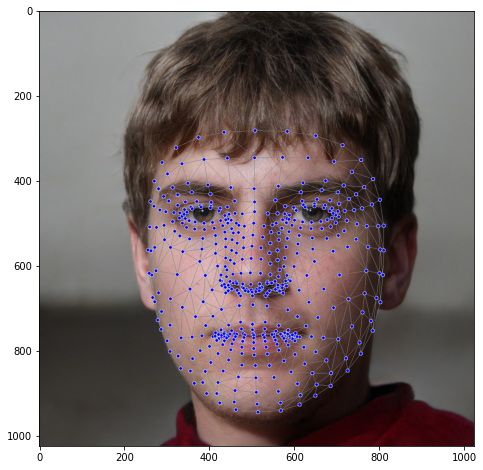

In [29]:
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        drawing.draw_landmarks(
            image=img,
            landmark_list=face_landmarks,
            connections=face_mesh.FACEMESH_TESSELATION,
            connection_drawing_spec=drawing_styles.get_default_face_mesh_tesselation_style()
            )
plt.imshow(img)
plt.savefig("../output/makeup/detection.png")

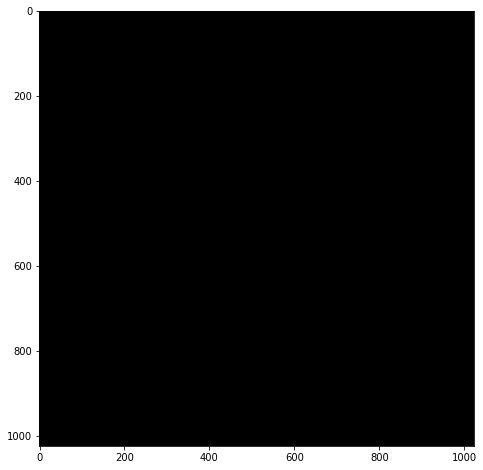

In [30]:
gray = np.zeros((src.shape[0], src.shape[1], 3), dtype=np.uint8)
plt.imshow(gray)

In [31]:
lips = list(face_mesh.FACEMESH_LIPS)
lips = np.ravel(lips)

In [32]:
l_eyes = list(face_mesh.FACEMESH_LEFT_EYE)
l_eyes = np.ravel(l_eyes)

r_eyes = list(face_mesh.FACEMESH_RIGHT_EYE)
r_eyes = np.ravel(r_eyes)

In [33]:
l_eyebrow = list(face_mesh.FACEMESH_LEFT_EYEBROW)
l_eyebrow = np.ravel(l_eyebrow)

r_eyebrow = list(face_mesh.FACEMESH_RIGHT_EYEBROW)
r_eyebrow = np.ravel(r_eyebrow)

In [34]:
face_dict = {}

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        
        ttt = []
        
        mask_lip = []
        mask_face = []
        mask_l_eyes = []
        mask_r_eyes = []
        mask_l_eyebrow = []
        mask_r_eyebrow = []
        for i in range(face_mesh.FACEMESH_NUM_LANDMARKS):
            
            if i in lips:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])
                
                mask_lip.append((x, y))

                
            elif i in l_eyes:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])

                mask_l_eyes.append((x, y))
            
            elif i in r_eyes:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])

                mask_r_eyes.append((x, y))
            
            elif i in r_eyebrow:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])

                mask_r_eyebrow.append((x, y))
            
            elif i in l_eyebrow:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])

                mask_l_eyebrow.append((x, y))
            
            
            else:
                pt1 = face_landmarks.landmark[i]
                x = int(pt1.x * img.shape[1])
                y = int(pt1.y * img.shape[0])

                mask_face.append((x, y))
                
    

face_dict["mask_lip"] = np.array(mask_lip)
face_dict["mask_face"] = np.array(mask_face)
face_dict["mask_l_eyes"] = np.array(mask_l_eyes)
face_dict["mask_r_eyes"] = np.array(mask_r_eyes)
face_dict["mask_l_eyebrow"] = np.array(mask_l_eyebrow)
face_dict["mask_r_eyebrow"] = np.array(mask_r_eyebrow)


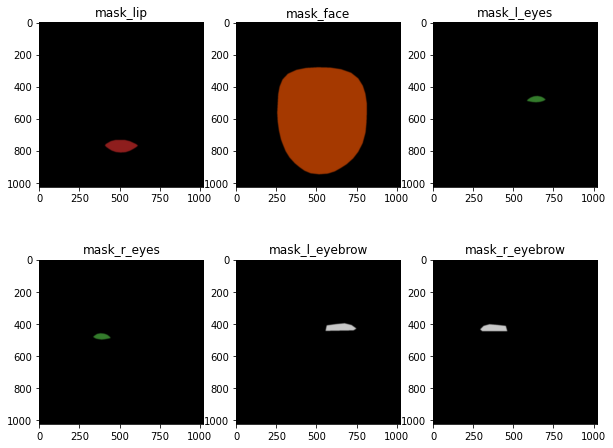

In [47]:
fig, axs = plt.subplots(2, len(face_dict.keys())//2)
axs = np.ravel(axs)

full_mask = gray.copy()

for idx, (part, v) in enumerate(face_dict.items()):
    mask = gray.copy()
    convexhull = cv2.convexHull(v)
    if "eyes" in part:
        color = cfg["eyes"]["color"]
        weight = cfg["eyes"]["weight"]
    elif "eyebrow" in part:
        color = cfg["eyebrow"]["color"]
        weight = cfg["eyebrow"]["weight"]

    elif "face" in part:
        color = cfg["face"]["color"]
        weight = cfg["face"]["weight"]

    elif "lip" in part:
        color = cfg["lip"]["color"]
        weight = cfg["lip"]["weight"]

    else:
        color = (0, 0, 0)
    
    mask = cv2.fillConvexPoly(mask, convexhull, color)
    mask = cv2.GaussianBlur(mask, (7, 7), 20)
    
    full_mask = cv2.addWeighted(full_mask, 1, mask, weight, 1)
    
    
    axs[idx].set_title(part)
    axs[idx].imshow(mask)

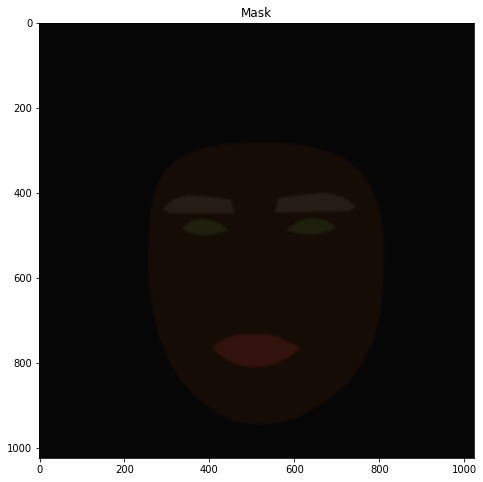

In [49]:
plt.title("Mask")
plt.imshow(full_mask)
plt.savefig("../output/makeup/Mask.png")

In [52]:
result = cv2.addWeighted(tmp, 1, src, 1, 1)
plt.savefig("../output/makeup/After.png")

<Figure size 720x576 with 0 Axes>

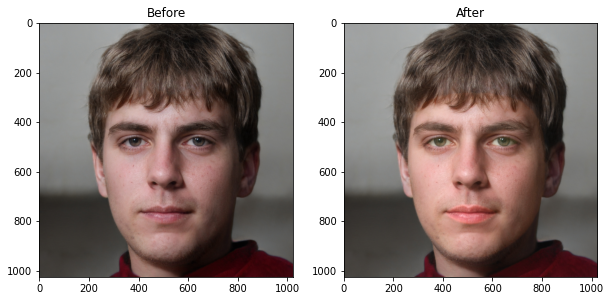

In [53]:

fig, (ax0, ax1) = plt.subplots(1,2)
ax0.set_title("Before")
ax0.imshow(src)
ax1.set_title("After")
ax1.imshow(result)